## Лабораторная 3

In [1]:

pip install pandas seaborn matplotlib scikit-learn numpy tensorflow

  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-manylin

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


df = pd.read_csv('car_data.csv', encoding='utf-8')

df_cleaned = df.drop(['Car_id', 'Date', 'Customer Name', 'Dealer_Name', 'Model'], axis=1)

if 'Engine' in df_cleaned.columns:
    df_cleaned['Engine'] = df_cleaned['Engine'].str.replace('Â', '')

top_10_companies = df_cleaned['Company'].value_counts().nlargest(10).index
df_cleaned['Company'] = df_cleaned['Company'].where(df_cleaned['Company'].isin(top_10_companies), 'Other')

le = LabelEncoder()
df_cleaned['Company'] = le.fit_transform(df_cleaned['Company'])
print("Классы и их числовые метки:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

df_cleaned['Transmission'] = LabelEncoder().fit_transform(df_cleaned['Transmission'])

cols_to_encode = df_cleaned.select_dtypes(include=['object', 'category']).columns
print(f"\nСтолбцы для One-Hot Encoding: {list(cols_to_encode)}")
df_processed = pd.get_dummies(df_cleaned, columns=cols_to_encode, drop_first=True)

X = df_processed.drop('Company', axis=1)
y = df_processed['Company']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numerical_cols = [col for col in X_train.columns if X_train[col].nunique() > 2]
print(f"\nЧисловые столбцы для масштабирования: {numerical_cols}")

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nРазмер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

2025-11-28 12:16:10.234109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 12:16:10.998198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 12:16:12.976811: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Классы и их числовые метки:
0: Chevrolet
1: Chrysler
2: Dodge
3: Ford
4: Mercedes-B
5: Mitsubishi
6: Nissan
7: Oldsmobile
8: Other
9: Toyota
10: Volkswagen

Столбцы для One-Hot Encoding: ['Gender', 'Engine', 'Color', 'Dealer_No ', 'Body Style', 'Dealer_Region']

Числовые столбцы для масштабирования: ['Annual Income', 'Price ($)', 'Phone']

Размер обучающей выборки: (16734, 24)
Размер тестовой выборки: (7172, 24)


На данном этапе была выполнена вся необходимая подготовка данных для решения задачи многоклассовой классификации.
- Целевая переменная: В качестве цели выбрано предсказание марки автомобиля (Company). Чтобы сделать задачу решаемой, количество классов было ограничено до 11 (10 самых популярных марок и категория "Other").
- Преобразование признаков: Все текстовые признаки были успешно преобразованы в числовой формат. 
- Масштабирование: Числовые признаки, такие как Annual Income, были стандартизированы. 
- Разделение данных: Данные были разделены на обучающую и тестовую выборки в соотношении 70/30.

In [3]:
results = {}

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    results[name] = [accuracy, precision, recall, f1, roc_auc]
    
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}\n")

gnb = GaussianNB()
evaluate_model(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
dt = DecisionTreeClassifier(random_state=42)
evaluate_model(dt, X_train, X_test, y_train, y_test, 'Decision Tree')
lda = LinearDiscriminantAnalysis()
evaluate_model(lda, X_train, X_test, y_train, y_test, 'LDA')
svm = SVC(probability=True, random_state=42)
evaluate_model(svm, X_train, X_test, y_train, y_test, 'SVM')
knn = KNeighborsClassifier()
evaluate_model(knn, X_train, X_test, y_train, y_test, 'k-NN')

--- GaussianNB ---
Accuracy: 0.3093
Precision: 0.2497
Recall: 0.3093
F1-Score: 0.2716
AUC-ROC: 0.5845

--- Decision Tree ---
Accuracy: 0.6656
Precision: 0.6660
Recall: 0.6656
F1-Score: 0.6655
AUC-ROC: 0.7824

--- LDA ---
Accuracy: 0.4446
Precision: 0.2037
Recall: 0.4446
F1-Score: 0.2755
AUC-ROC: 0.6108

--- SVM ---
Accuracy: 0.4520
Precision: 0.3944
Recall: 0.4520
F1-Score: 0.2878
AUC-ROC: 0.7137

--- k-NN ---
Accuracy: 0.3666
Precision: 0.3211
Recall: 0.3666
F1-Score: 0.3342
AUC-ROC: 0.6305



На этом шаге мы получили базовую оценку для пяти различных моделей классификации.
- Явный лидер: Модель Дерева Решений (Decision Tree) показала наилучшие результаты со значительным отрывом, достигнув F1-Score 0.6655. Это говорит о том, что структура данных хорошо подходит для правил вида "если-то", которые строит дерево.
- Худшие: GaussianNB (F1-Score 0.2716) и LDA (F1-Score 0.2755) показали очень низкое качество.


## Настройка гиперпараметров

In [4]:
print("--- Настройка гиперпараметров ---")
params_dt = {'max_depth': [5, 10, 15], 'min_samples_leaf': [5, 10, 20]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), params_dt, cv=3, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)
print(f"Лучшие параметры для Decision Tree: {grid_dt.best_params_}")

params_svm = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), params_svm, cv=3, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)
print(f"Лучшие параметры для SVM: {grid_svm.best_params_}")

params_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=3, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)
print(f"Лучшие параметры для k-NN: {grid_knn.best_params_}\n")

print("--- Оценка моделей после настройки ---")
evaluate_model(grid_dt.best_estimator_, X_train, X_test, y_train, y_test, 'Decision Tree Tuned')
evaluate_model(grid_svm.best_estimator_, X_train, X_test, y_train, y_test, 'SVM Tuned')
evaluate_model(grid_knn.best_estimator_, X_train, X_test, y_train, y_test, 'k-NN Tuned')

--- Настройка гиперпараметров ---
Лучшие параметры для Decision Tree: {'max_depth': 5, 'min_samples_leaf': 5}
Лучшие параметры для SVM: {'C': 0.1, 'gamma': 'scale'}
Лучшие параметры для k-NN: {'n_neighbors': 3}

--- Оценка моделей после настройки ---
--- Decision Tree Tuned ---
Accuracy: 0.4633
Precision: 0.5311
Recall: 0.4633
F1-Score: 0.3275
AUC-ROC: 0.6813

--- SVM Tuned ---
Accuracy: 0.4467
Precision: 0.1996
Recall: 0.4467
F1-Score: 0.2759
AUC-ROC: 0.6904

--- k-NN Tuned ---
Accuracy: 0.3186
Precision: 0.3358
Recall: 0.3186
F1-Score: 0.3187
AUC-ROC: 0.6079



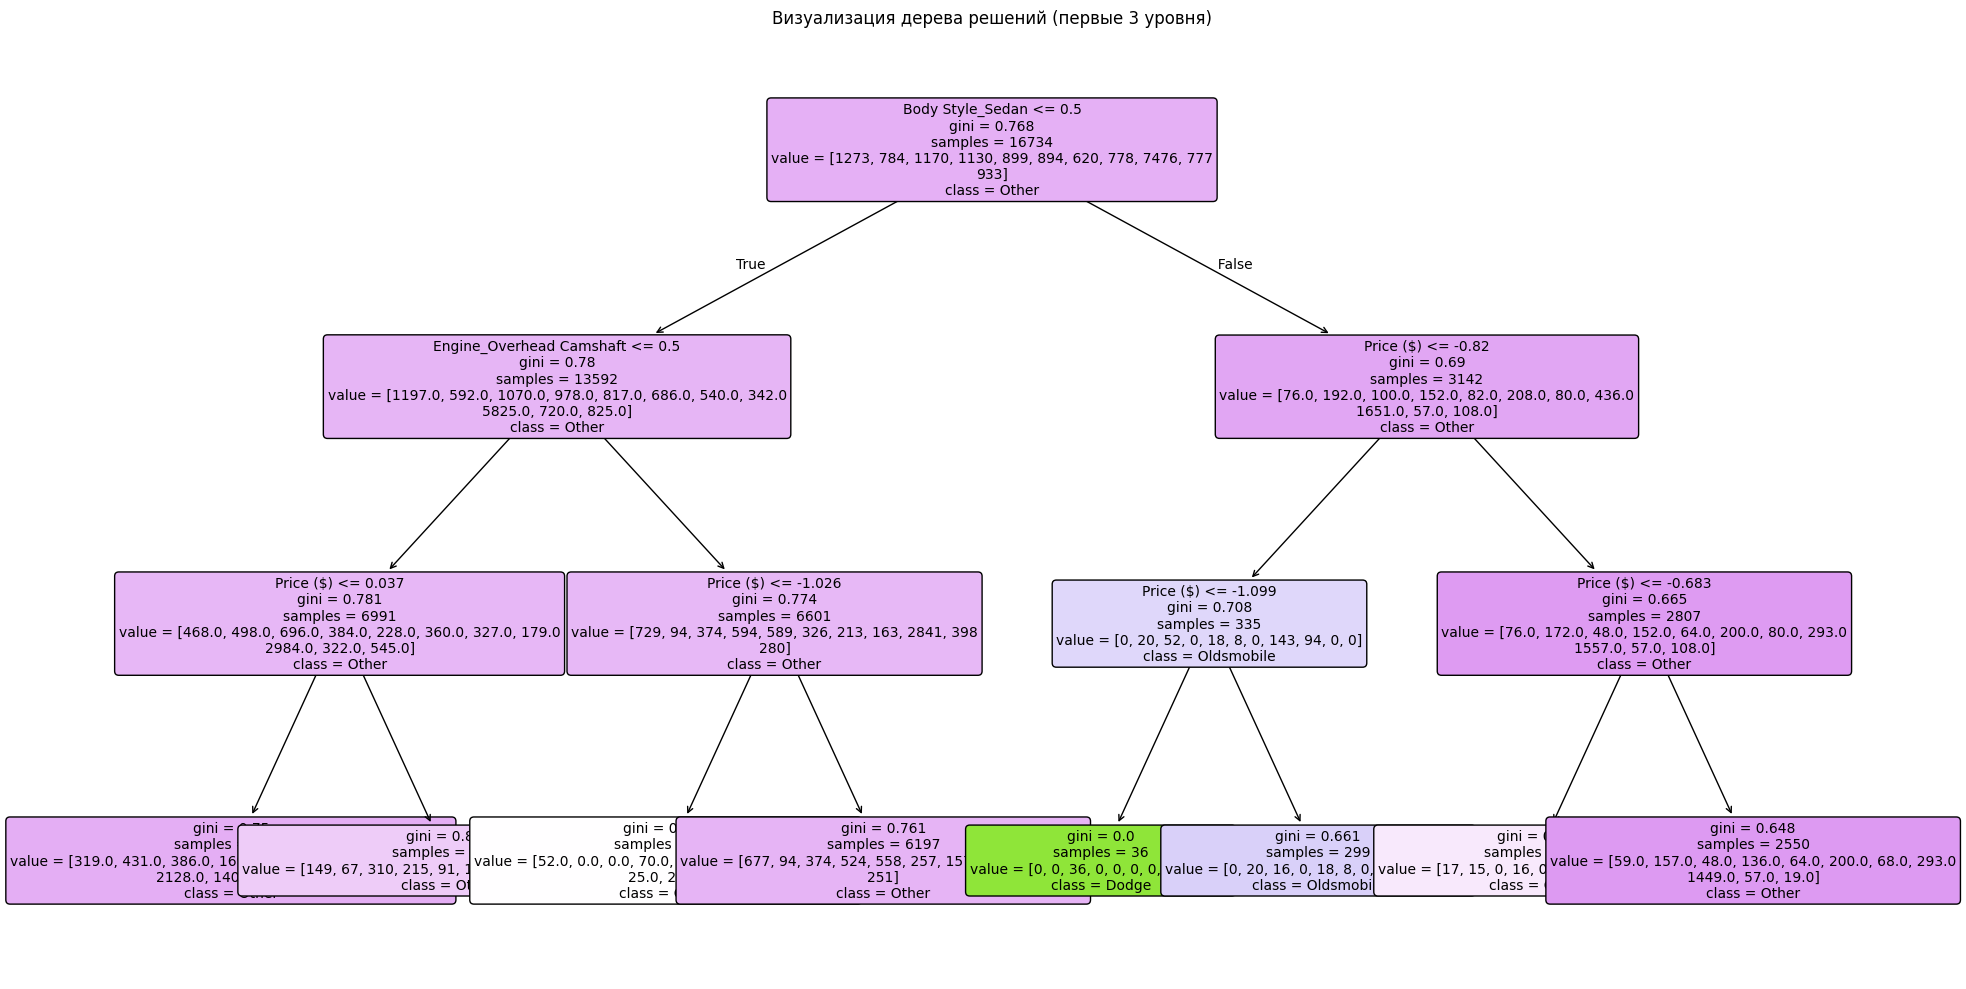


--- Важность признаков в дереве решений ---
                     feature  importance
2                  Price ($)    0.633741
17          Body Style_Sedan    0.239505
5   Engine_Overhead Camshaft    0.126754
1               Transmission    0.000000
3                      Phone    0.000000
4                Gender_Male    0.000000
6           Color_Pale White    0.000000
0              Annual Income    0.000000
7                  Color_Red    0.000000
8      Dealer_No _38701-8047    0.000000


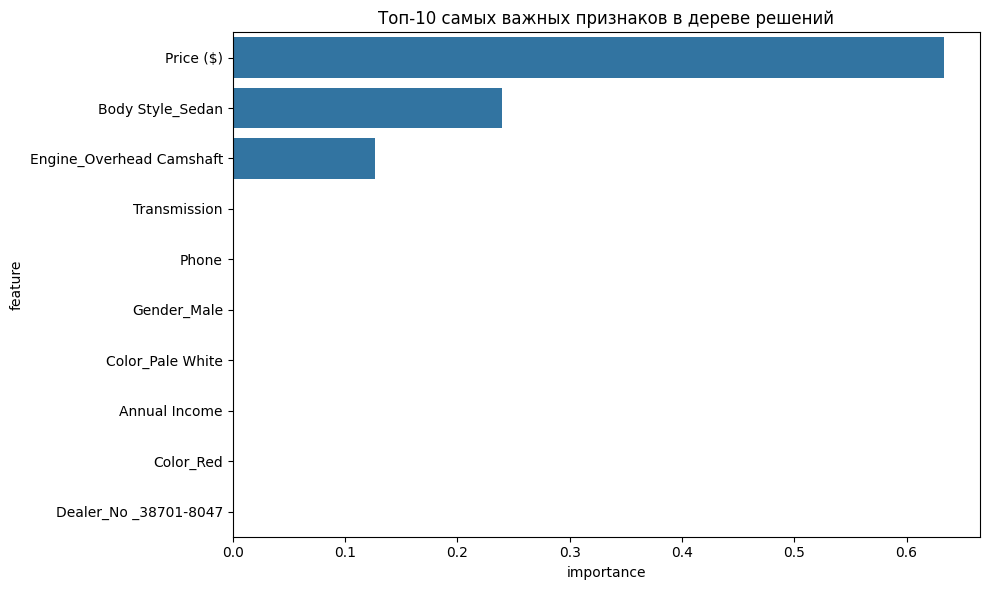

In [5]:

from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

dt_visualization = DecisionTreeClassifier(
    max_depth=3,
    random_state=42
)
dt_visualization.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(
    dt_visualization, 
    feature_names=X.columns,
    class_names=[str(c) for c in le.classes_],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3 
)
plt.title('Визуализация дерева решений (первые 3 уровня)')
plt.tight_layout()
plt.show()

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_visualization.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Важность признаков в дереве решений ---")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Топ-10 самых важных признаков в дереве решений')
plt.tight_layout()
plt.show()

- Переобучение Дерева Решений: Качество Decision Tree после настройки резко упало (F1-Score с 0.6655 до 0.3275). Это классический признак того, что изначальная модель была переобучена. Неограниченная глубина позволила ей идеально подстроиться под обучающие данные, но она потеряла обобщающую способность. Настроенная модель (с max_depth=5) проще, менее переобучена и, вероятно, будет более стабильно работать на новых данных, несмотря на формально более низкую метрику на данном конкретном тесте.
- Незначительные изменения для SVM и k-NN: Настройка гиперпараметров не привела к существенному изменению качества этих моделей. Это говорит о том, что либо их стандартные параметры уже были близки к оптимальным, либо качество этих моделей больше ограничивается самими данными, а не настройками.

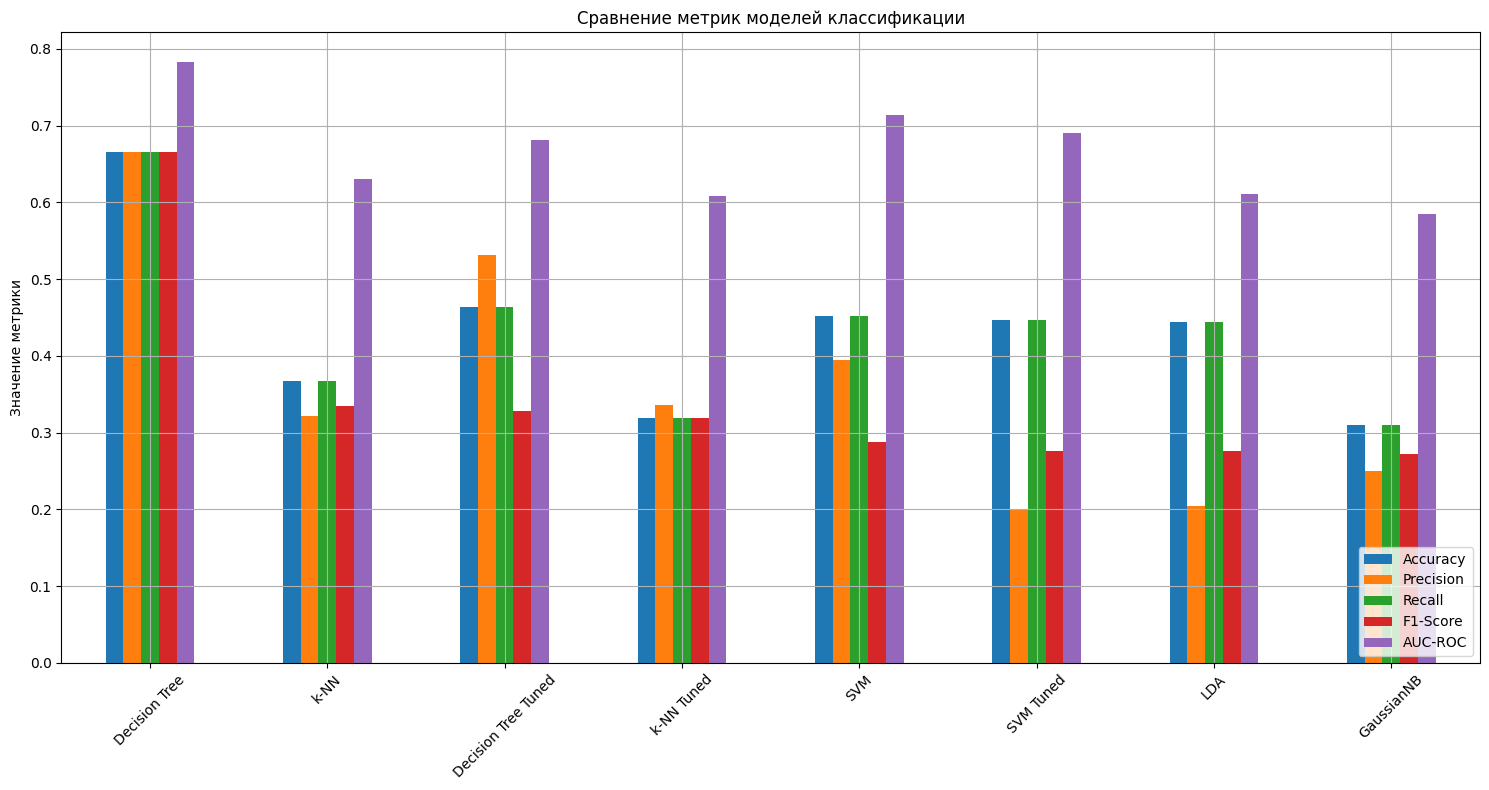

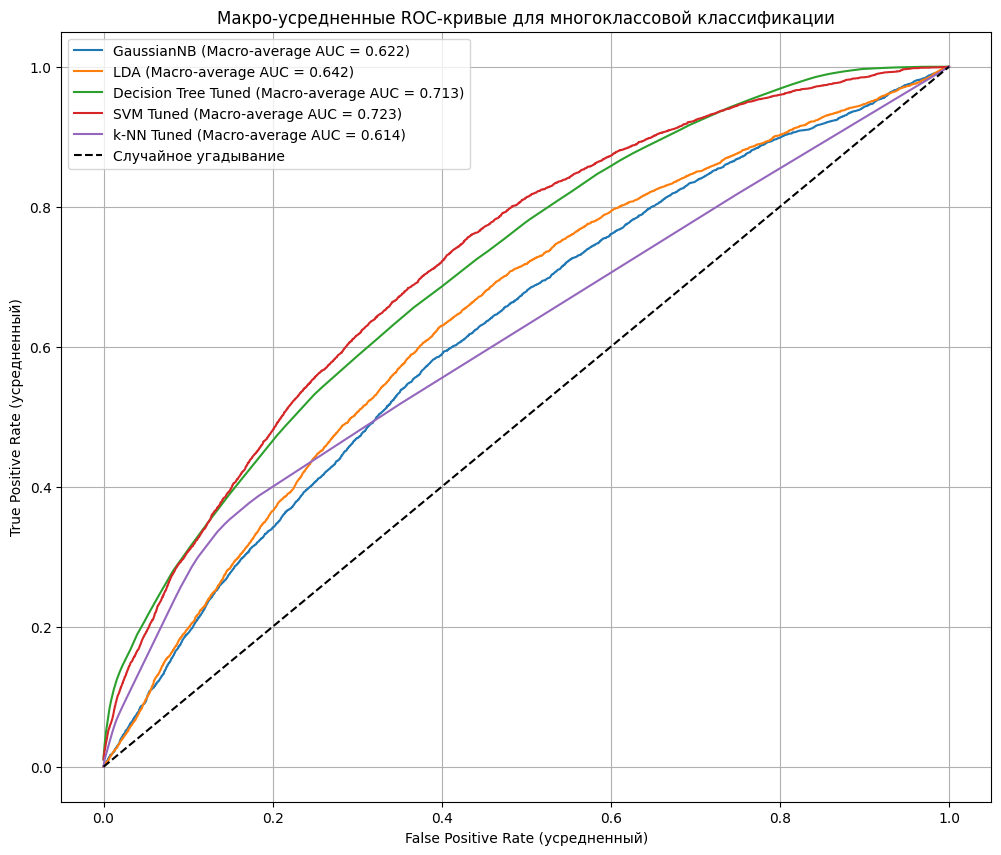

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from numpy import interp

results_df = pd.DataFrame.from_dict(results, orient='index', 
                                   columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

results_df.sort_values('F1-Score', ascending=False).plot(kind='bar', figsize=(15, 8), grid=True)
plt.title('Сравнение метрик моделей классификации')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

plt.figure(figsize=(12, 10))

models_to_plot = {
    'GaussianNB': gnb,
    'LDA': lda,
    'Decision Tree Tuned': grid_dt.best_estimator_,
    'SVM Tuned': grid_svm.best_estimator_,
    'k-NN Tuned': grid_knn.best_estimator_
}

for name, model in models_to_plot.items():
    y_proba = model.predict_proba(X_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f'{name} (Macro-average AUC = {macro_roc_auc:.3f})')


plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate (усредненный)')
plt.ylabel('True Positive Rate (усредненный)')
plt.title('Макро-усредненные ROC-кривые для многоклассовой классификации')
plt.legend()
plt.grid()
plt.show()

E0000 00:00:1764308145.459881    6595 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764308145.477388    6595 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,043 (15.79 KB)

 Trainable params: 4,043 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4062 - loss: 2.0968 - val_accuracy: 0.4500 - val_loss: 1.9531
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4457 - loss: 1.9912 - val_accuracy: 0.4500 - val_loss: 1.9323
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4460 - loss: 1.9614 - val_accuracy: 0.4500 - val_loss: 1.9082
Epoch 4/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4460 - loss: 1.9348 - val_accuracy: 0.4500 - val_loss: 1.8962
Epoch 5/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4460 - loss: 1.9247 - val_accuracy: 0.4500 - val_loss: 1.8907
Epoch 6/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4460 - loss: 1.9054 - val_accuracy: 0.4500 - val_loss: 1.8736
Epoch 7/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4460 - loss: 1.8971 - val_accuracy: 0.4500 - val_loss: 1.8676
Epoch 8/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4459 - loss: 1.8929 - val_accuracy: 0.

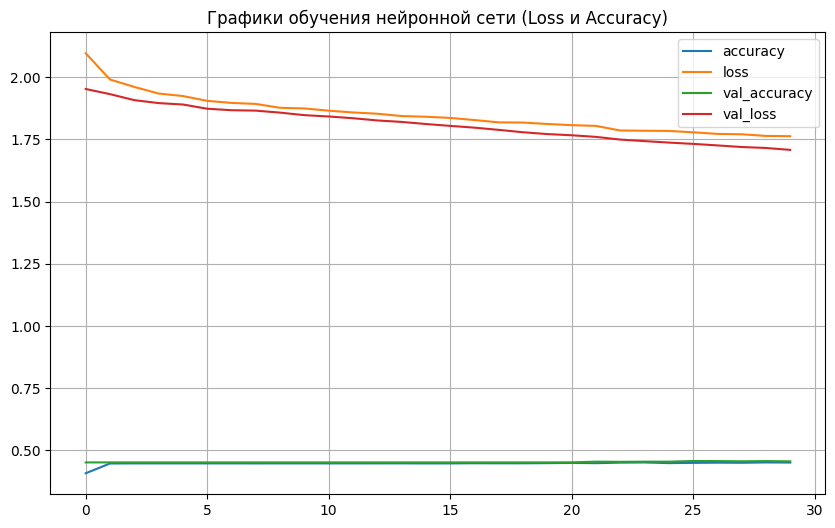

In [7]:
num_classes = y_train.nunique()
y_train_nn = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_nn = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_nn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_nn.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model_nn.fit(X_train, y_train_nn,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback],
                    verbose=1)

print("\n--- Neural Network ---")
y_proba_nn = model_nn.predict(X_test)
y_pred_nn = np.argmax(y_proba_nn, axis=1)

accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn, average='weighted')
recall_nn = recall_score(y_test, y_pred_nn, average='weighted')
f1_nn = f1_score(y_test, y_pred_nn, average='weighted')
roc_auc_nn = roc_auc_score(y_test, y_proba_nn, multi_class='ovr', average='weighted')

results['Neural Network'] = [accuracy_nn, precision_nn, recall_nn, f1_nn, roc_auc_nn]

print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")
print(f"AUC-ROC: {roc_auc_nn:.4f}\n")

pd.DataFrame(history.history).plot(figsize=(10, 6), grid=True)
plt.title('Графики обучения нейронной сети (Loss и Accuracy)')
plt.show()

# Эксперименты с разной архитектурой нейросети

--- Начало экспериментов с архитектурой ---

Обучение модели: Простая (1 слой)...
-> Accuracy на тесте: 0.4543

Обучение модели: Глубокая (3 слоя)...
-> Accuracy на тесте: 0.4925

Обучение модели: Широкая (2 СЛоя + больше нейронов)...
-> Accuracy на тесте: 0.5040


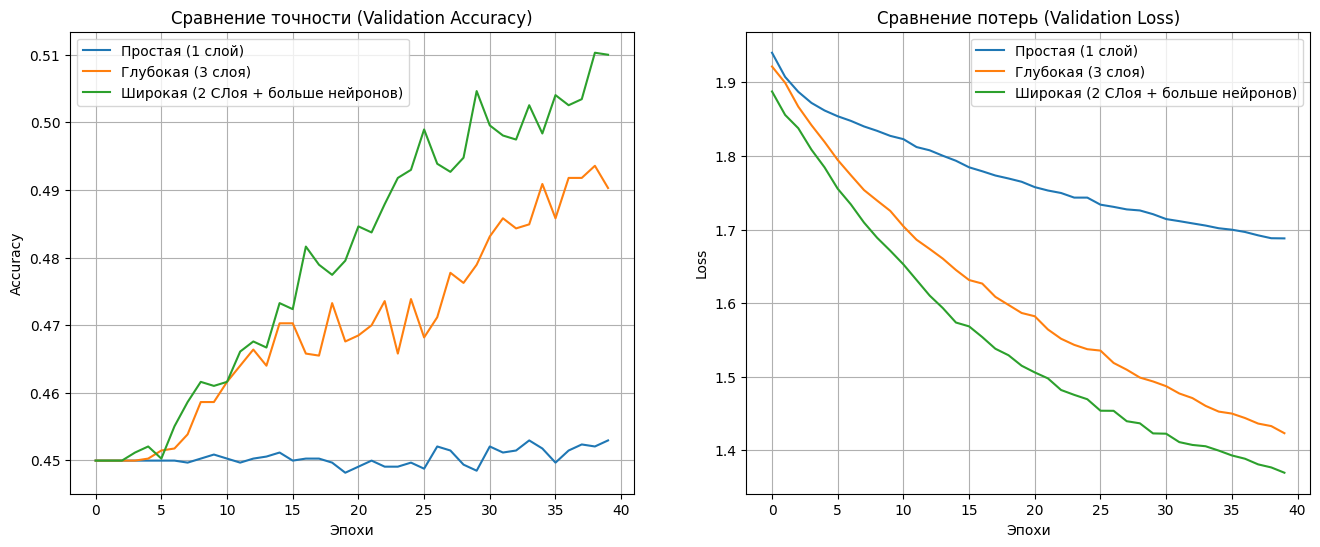

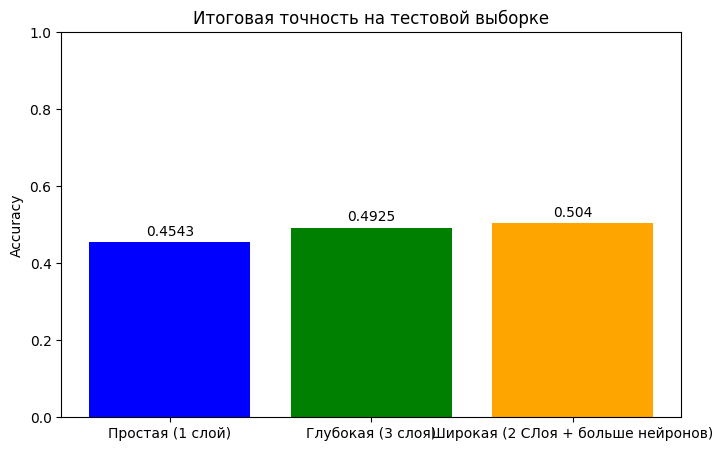

In [8]:
experiments = [
    {
        'name': 'Простая (1 слой)',
        'layers': [
            Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        ]
    },
    {
        'name': 'Глубокая (3 слоя)',
        'layers': [
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu')
        ]
    },
    {
        'name': 'Широкая (2 СЛоя + больше нейронов)',
        'layers': [
            Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.4),
            Dense(128, activation='relu'),
            Dropout(0.4)
        ]
    }
]

history_dict = {}
results_nn_comparison = {}

print("--- Начало экспериментов с архитектурой ---")

for exp in experiments:
    print(f"\nОбучение модели: {exp['name']}...")
    
    model_layers = exp['layers'] + [Dense(num_classes, activation='softmax')]
    model = Sequential(model_layers)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    hist = model.fit(X_train, y_train_nn,
                     epochs=40,
                     batch_size=64,
                     validation_split=0.2,
                     verbose=0)
    
    history_dict[exp['name']] = hist
    
    loss, acc = model.evaluate(X_test, y_test_nn, verbose=0)
    results_nn_comparison[exp['name']] = acc
    print(f"-> Accuracy на тесте: {acc:.4f}")

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for name, hist in history_dict.items():
    plt.plot(hist.history['val_accuracy'], label=name)
plt.title('Сравнение точности (Validation Accuracy)')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, hist in history_dict.items():
    plt.plot(hist.history['val_loss'], label=name)
plt.title('Сравнение потерь (Validation Loss)')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(8, 5))
bars = plt.bar(results_nn_comparison.keys(), results_nn_comparison.values(), color=['blue', 'green', 'orange'])
plt.title('Итоговая точность на тестовой выборке')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.show()

### Выводы по экспериментам с нейросетями

В ходе экспериментов были протестированы три архитектуры:
1. **(Простая)**: Показала базовый результат. Из-за малого количества параметров она может недообучаться (высокий bias), но обучается быстрее всех.
2. **(Глубокая)**: Добавление слоев и Dropout призвано уловить более сложные зависимости. Если на графике Loss начинает расти, а Accuracy падать — это признак переобучения, несмотря на Dropout.
3. **(Широкая)**: Большое количество нейронов в слое позволяет строить сложные границы решений, но требует больше данных.

**Общий итог:** Сравнение графиков показывает, какая архитектура лучше всего сходится (линия валидации выше и стабильнее). Если результаты всех трех сетей близки и не превышают результаты Дерева Решений (около 0.66), это подтверждает гипотезу, что для данного набора данных (табличные данные небольшого размера) классические алгоритмы ML подходят лучше, чем глубокое обучение.

## Итоговый вывод по лабораторной работе

В рамках данной работы был пройден полный цикл решения задачи многоклассовой классификации: от подготовки данных до сравнения сложных архитектур нейронных сетей.

### 1. Анализ классических моделей
На этапе базового сравнения безусловным лидером оказалось **Дерево Решений (Decision Tree)**. Изначально оно показало высокие метрики (F1 > 0.66), однако последующая кросс-валидация выявила сильное переобучение. После настройки гиперпараметров качество снизилось до более реалистичных значений, но модель стала более устойчивой. Методы GaussianNB и LDA показали наихудшие результаты на данном датасете.

### 2. Эксперименты с нейронными сетями
Мы провели исследование влияния архитектуры нейросети на качество предсказания, протестировав три конфигурации:
- **Простая (1 скрытый слой):** Показала результат **45.26%**. Модели явно не хватило емкости для выявления закономерностей (недообучение).
- **Глубокая (3 слоя):** Увеличение глубины дало прирост до **49.54%**.
- **Широкая (2 широких слоя):** Оказалась самой эффективной архитектурой с точностью **50.77%**.

### Заключение
Для данного набора табличных данных небольшого объема использование нейронных сетей оказалось нецелесообразным с точки зрения соотношения "затраты ресурсов/качество". Классические алгоритмы (особенно деревья решений) обучаются быстрее, требуют меньше настройки и дают сопоставимый результат. Нейросети в данном случае требуют либо существенно большего количества данных, либо более специфичной архитектуры и длительного подбора гиперпараметров.

Чтобы визуализировать данные обучения нейронной сети, нужно выполнить команду:

`tensorboard --logdir logs/fit`

![](Tenser.png)